In [1]:
from json2dag.models.DAG import dag_from_causes_dict, model_from_dag
from json2dag.models.relations import partial_with_docs, geometric_adstock
import numpy as np
import pymc as pm
from IPython.display import Image
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


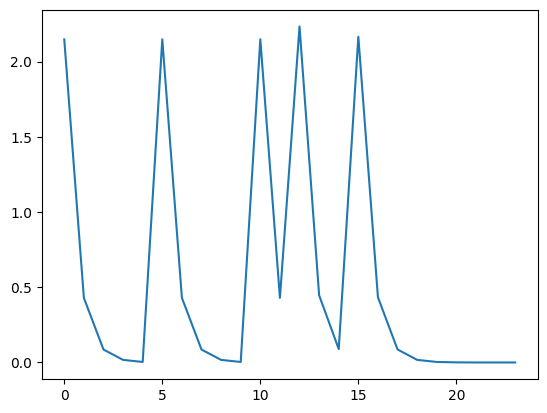

In [2]:
test_conv = np.zeros(24)
test_conv[0] = 10.
test_conv[5] = 10.
test_conv[10] = 10.
test_conv[12] = 10.
test_conv[15] = 10.
plt.plot(np.convolve(test_conv, np.array([.2**t for t in range(12)])/sum([.8**t for t in range(12)]), mode='full')[:len(test_conv)])

In [3]:
simple_graph = {"A": [dict(name="B", op=partial_with_docs(geometric_adstock, normalize=True), prior_constraint='positive')]}
simple_dag = dag_from_causes_dict(simple_graph)
Image(simple_dag.graph)
for node in simple_dag.nodes:
  if node.name == 'A':
    node.value = test_conv


In [10]:
for edge in simple_dag.edges:
  if edge.parent.name == 'A' and edge.child.name == 'B':
    edge.child.value = edge.apply(.4).eval()

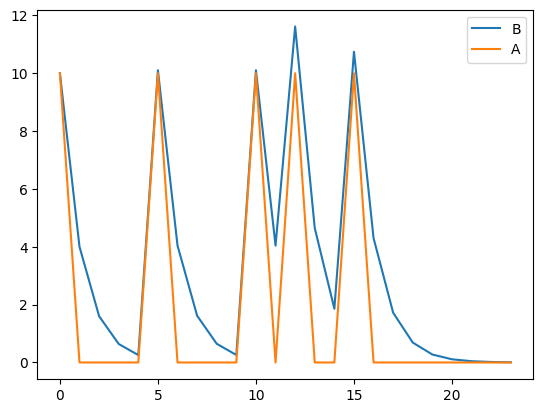

In [11]:
for node in simple_dag.nodes:
  plt.plot(node.value, label=node.name)
plt.legend()

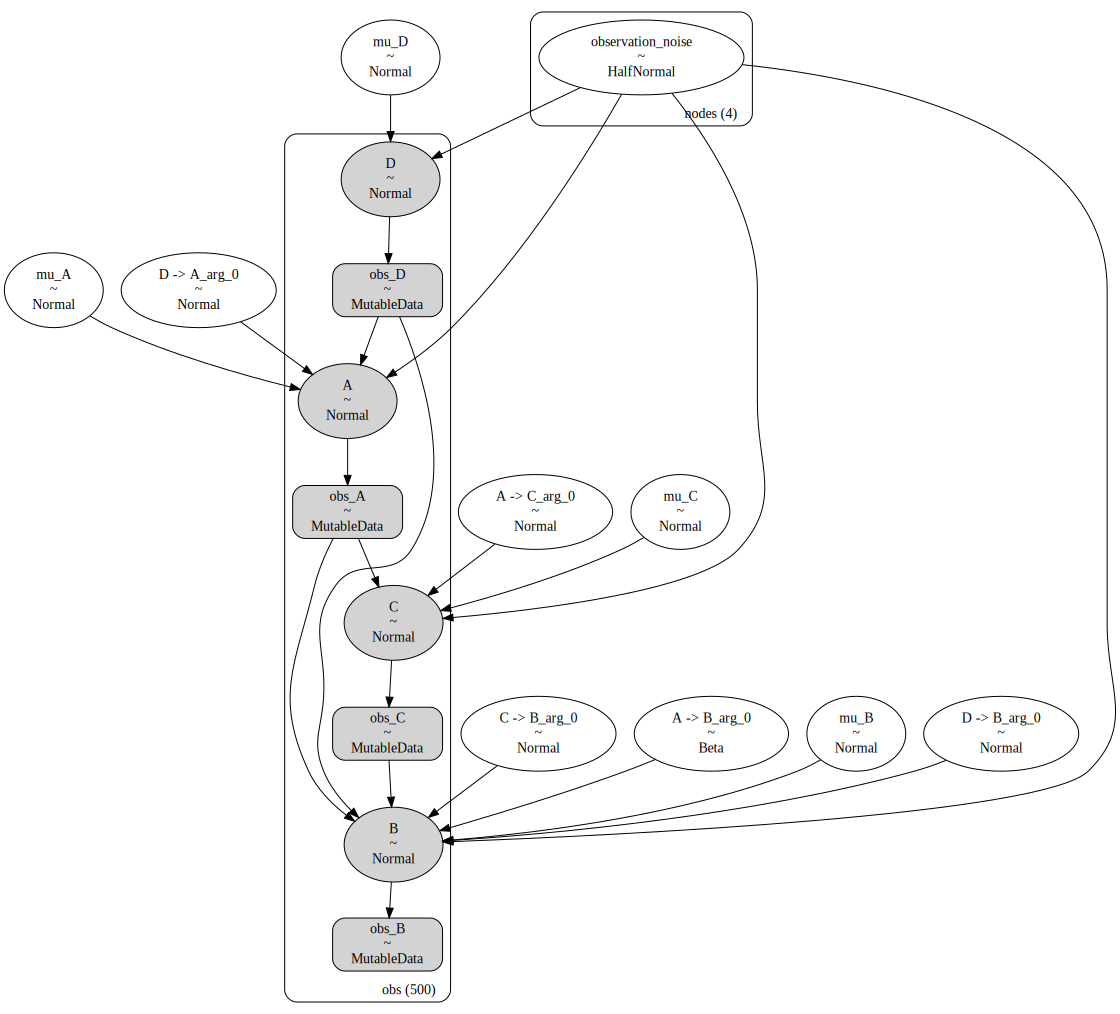

In [13]:
sample_size = 500
causes = {"A": [dict(name="B", op=partial_with_docs(geometric_adstock, normalize=True), prior_constraint='positive'), dict(name="C")], 
          "C": [dict(name="B")], 
          "D": [dict(name="B"), dict(name="A")]}
my_dag = dag_from_causes_dict(causes)

D = np.random.normal(0, 2, size=sample_size)
A = 10.0 + 2*D + np.random.normal(0, 3, size=sample_size)
C = 1.0 + 1*A + np.random.normal(0, 3, size=sample_size)
B = 3.0 + np.convolve(A, np.array([.2**t for t in range(12)])/sum([.2**t for t in range(12)]), mode='full')[:len(A)]- 1.0*C - 2.0*D + np.random.normal(0, .1, size=sample_size)

sub_dag = dag_from_causes_dict({"D": causes["D"]})
my_dag_model = model_from_dag(my_dag, observations={'A': A, "B": B, "C": C, "D": D})
pm.model_to_graphviz(my_dag_model)

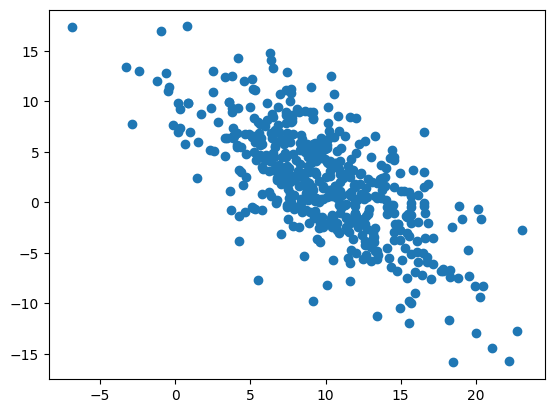

In [14]:
plt.scatter(A, B)

In [15]:
with my_dag_model:
    trace = pm.sample(1000, tune=1500, target_accept=.9, cores=4, nuts_sampler="numpyro")

Compiling...
Compilation time = 0:00:03.544924
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:03.492802
Transforming variables...
Transforming variables...
Transformation time = 0:00:00.080786


In [16]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
D -> A_arg_0,1.911,0.069,1.787,2.044,0.001,0.001,4776.0,2677.0,1.0
D -> B_arg_0,-2.200,0.013,-2.224,-2.174,0.000,0.000,3696.0,2794.0,1.0
A -> C_arg_0,1.010,0.027,0.959,1.058,0.000,0.000,3104.0,2777.0,1.0
C -> B_arg_0,-1.097,0.005,-1.105,-1.088,0.000,0.000,3511.0,3160.0,1.0
mu_C,1.001,0.285,0.485,1.547,0.005,0.004,3063.0,2714.0,1.0
mu_B,2.210,0.075,2.060,2.345,0.001,0.001,2954.0,2219.0,1.0
mu_D,-0.033,0.085,-0.192,0.126,0.001,0.001,5415.0,2506.0,1.0
mu_A,9.816,0.126,9.564,10.033,0.002,0.001,5066.0,3234.0,1.0
observation_noise[C],2.885,0.089,2.722,3.054,0.001,0.001,4489.0,2745.0,1.0
observation_noise[B],0.418,0.013,0.394,0.444,0.000,0.000,5405.0,3084.0,1.0


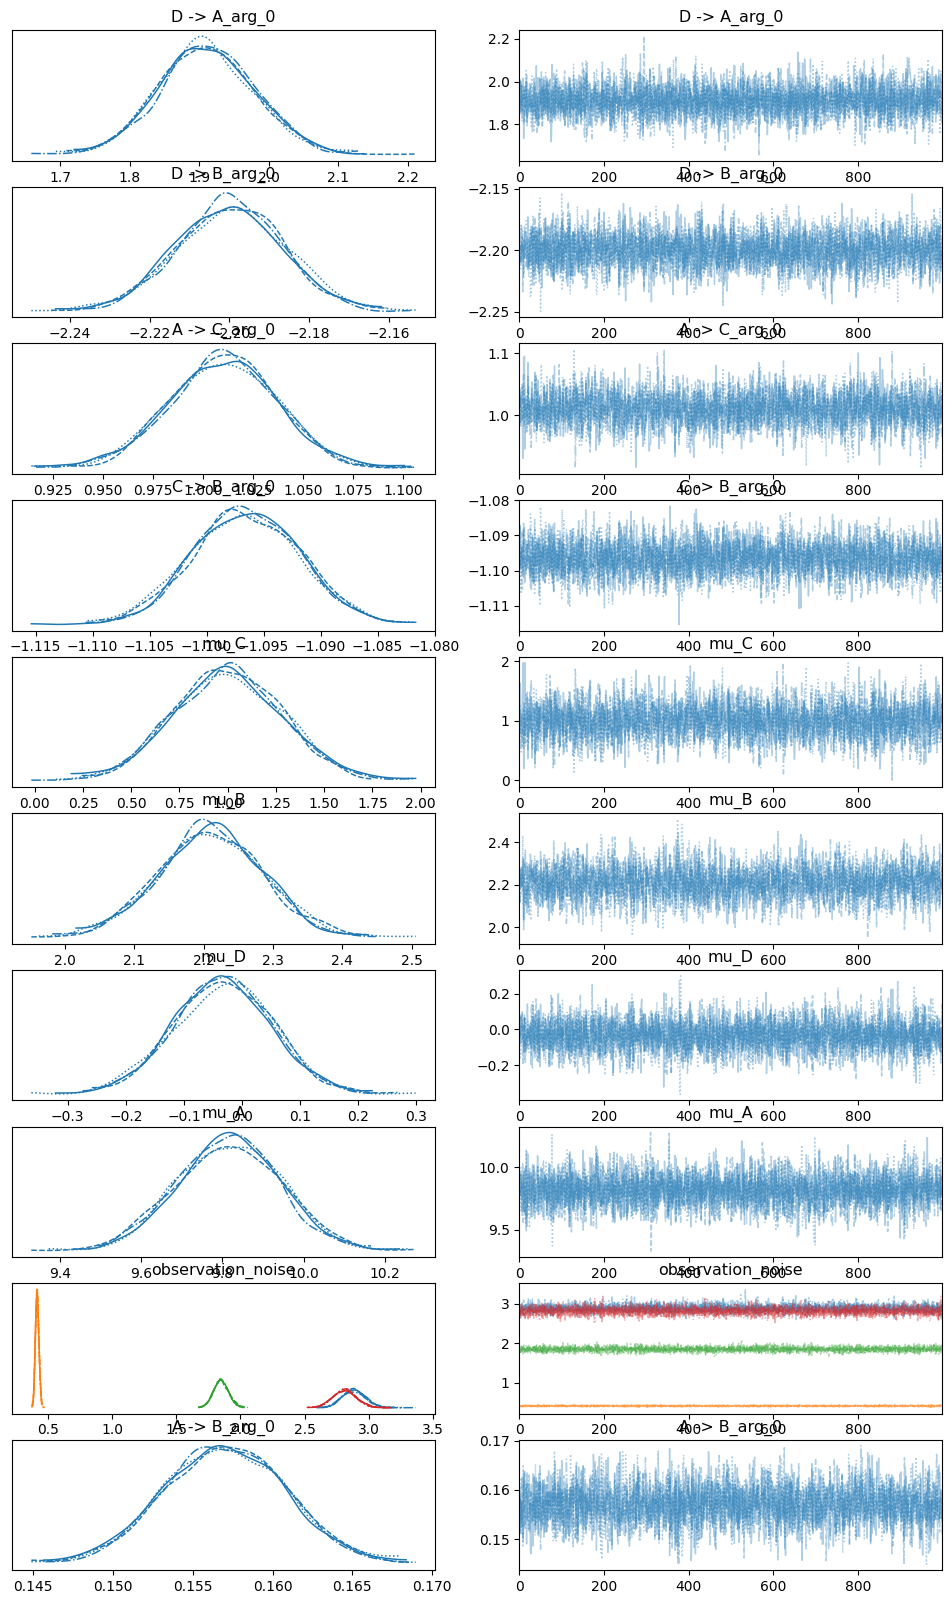

In [17]:
pm.plot_trace(trace);

In [17]:
import dowhy
import pandas as pd

In [18]:
df = pd.DataFrame({"A": A, "B": B, "C": C, "D": D})

In [32]:
repr(my_dag).replace("\n\t", "; ")

'digraph {; A [label="A=obs_A"]; D [label="D=obs_D"]; C [label="C=obs_C"]; B [label="B=obs_B"]; A -> B [label="Linear Function"]; D -> A [label="Linear Function"]; D -> B [label="Linear Function"]; C -> B [label="Linear Function"]; A -> C [label="Linear Function"]\n}\n'

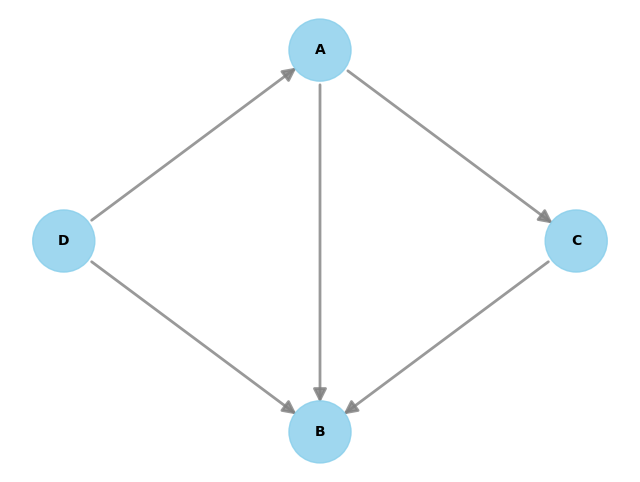

In [25]:
from dowhy import CausalModel
from IPython.display import Image, display
model= CausalModel(
        data = df,
        graph=repr(my_dag).replace("\n", "; ").replace("{;", "{"),
        treatment='D',
        outcome='A')
model.view_model()

In [26]:
estimands = model.identify_effect()
print(estimands)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[A])
d[D]      
Estimand assumption 1, Unconfoundedness: If U→{D} and U→A then P(A|D,,U) = P(A|D,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [31]:
estimands.estimands

{'backdoor1': {'estimand': Derivative(Expectation(A), [D]),
  'assumptions': {'Unconfoundedness': 'If U→{D} and U→A then P(A|D,,U) = P(A|D,)'}},
 'backdoor': {'estimand': Derivative(Expectation(A), [D]),
  'assumptions': {'Unconfoundedness': 'If U→{D} and U→A then P(A|D,,U) = P(A|D,)'}},
 'iv': None,
 'frontdoor': None}

In [28]:
#Causal Effect Estimation
estimate = model.estimate_effect(estimands,method_name = "backdoor.linear_regression")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[A])
d[D]      
Estimand assumption 1, Unconfoundedness: If U→{D} and U→A then P(A|D,,U) = P(A|D,)

## Realized estimand
b: A~D
Target units: ate

## Estimate
Mean value: 2.0003097501112332



/home/mattr/.cache/pypoetry/virtualenvs/json2dag-JeLZi7NZ-py3.10/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [29]:
refutel = model.refute_estimate(estimands,estimate, "random_common_cause")
print(refutel)

/home/mattr/.cache/pypoetry/virtualenvs/json2dag-JeLZi7NZ-py3.10/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/mattr/.cache/pypoetry/virtualenvs/json2dag-JeLZi7NZ-py3.10/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/mattr/.cache/pypoetry/virtualenvs/json2dag-JeLZi7NZ-py3.10/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: Futur

Refute: Add a random common cause
Estimated effect:2.0003097501112332
New effect:2.0004102354334945
p value:0.98



/home/mattr/.cache/pypoetry/virtualenvs/json2dag-JeLZi7NZ-py3.10/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/mattr/.cache/pypoetry/virtualenvs/json2dag-JeLZi7NZ-py3.10/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/mattr/.cache/pypoetry/virtualenvs/json2dag-JeLZi7NZ-py3.10/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: Futur

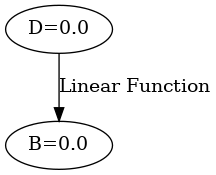

In [6]:
sub_dag = dag_from_causes_dict({"D": [causes["D"][0]]})
Image(sub_dag.graph)

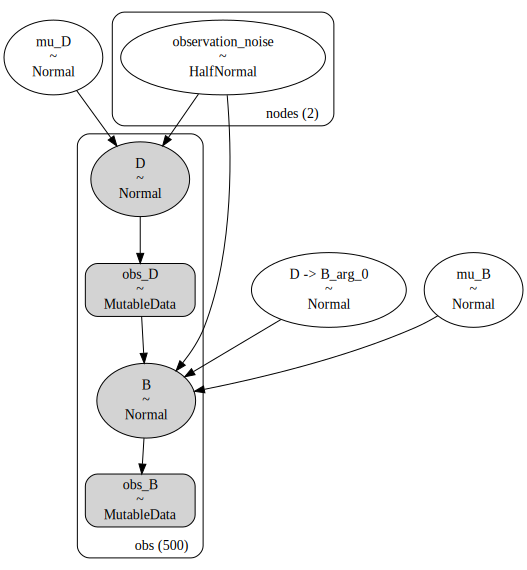

In [7]:
sub_dag_model = model_from_dag(sub_dag, observations={"B": B, "D": D})
pm.model_to_graphviz(sub_dag_model)

In [8]:
with sub_dag_model:
  sub_trace = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_noise, D -> B_arg_0, mu_D, mu_B]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [9]:
with my_dag_model:
  trace = pm.sample(1_000, tune=1_000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_noise, A -> B_arg_0, D -> A_arg_0, D -> B_arg_0, C -> B_arg_0, A -> C_arg_0, mu_A, mu_D, mu_C, mu_B]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [10]:
pm.summary(trace, filter_vars='regex')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A -> B_arg_0,2.022,0.026,1.972,2.071,0.001,0.000,2743.0,2314.0,1.0
D -> A_arg_0,1.996,0.046,1.912,2.086,0.001,0.000,5239.0,2908.0,1.0
D -> B_arg_0,-2.023,0.051,-2.122,-1.930,0.001,0.001,2813.0,2540.0,1.0
C -> B_arg_0,-0.996,0.012,-1.017,-0.973,0.000,0.000,4189.0,2798.0,1.0
A -> C_arg_0,1.027,0.037,0.956,1.094,0.001,0.000,3206.0,2840.0,1.0
mu_A,10.110,0.089,9.941,10.274,0.001,0.001,6409.0,2966.0,1.0
mu_D,-0.015,0.090,-0.191,0.146,0.001,0.001,5534.0,2917.0,1.0
mu_C,0.831,0.399,0.083,1.577,0.007,0.005,3290.0,2658.0,1.0
mu_B,2.679,0.234,2.217,3.098,0.004,0.003,2861.0,2515.0,1.0
observation_noise[A],2.033,0.064,1.917,2.155,0.001,0.001,5290.0,2676.0,1.0


In [11]:
pm.summary(sub_trace, filter_vars='regex')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
D -> B_arg_0,0.025,0.101,-0.160,0.213,0.001,0.001,6526.0,3335.0,1.0
mu_D,-0.014,0.088,-0.177,0.149,0.001,0.001,6908.0,3074.0,1.0
mu_B,11.563,0.199,11.205,11.944,0.003,0.002,5592.0,3037.0,1.0
observation_noise[D],1.968,0.062,1.851,2.083,0.001,0.001,5703.0,2888.0,1.0
observation_noise[B],4.459,0.139,4.220,4.732,0.002,0.001,7074.0,3436.0,1.0


In [12]:
posterior = pm.sample_posterior_predictive(trace, model=my_dag_model)

Sampling: [A, B, C, D]


/home/mattr/.cache/pypoetry/virtualenvs/json2dag-JeLZi7NZ-py3.10/lib/python3.10/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/home/mattr/.cache/pypoetry/virtualenvs/json2dag-JeLZi7NZ-py3.10/lib/python3.10/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


array([<Axes: xlabel='A'>, <Axes: xlabel='D'>, <Axes: xlabel='C'>,
       <Axes: xlabel='B'>], dtype=object)

/home/mattr/.cache/pypoetry/virtualenvs/json2dag-JeLZi7NZ-py3.10/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/mattr/.cache/pypoetry/virtualenvs/json2dag-JeLZi7NZ-py3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


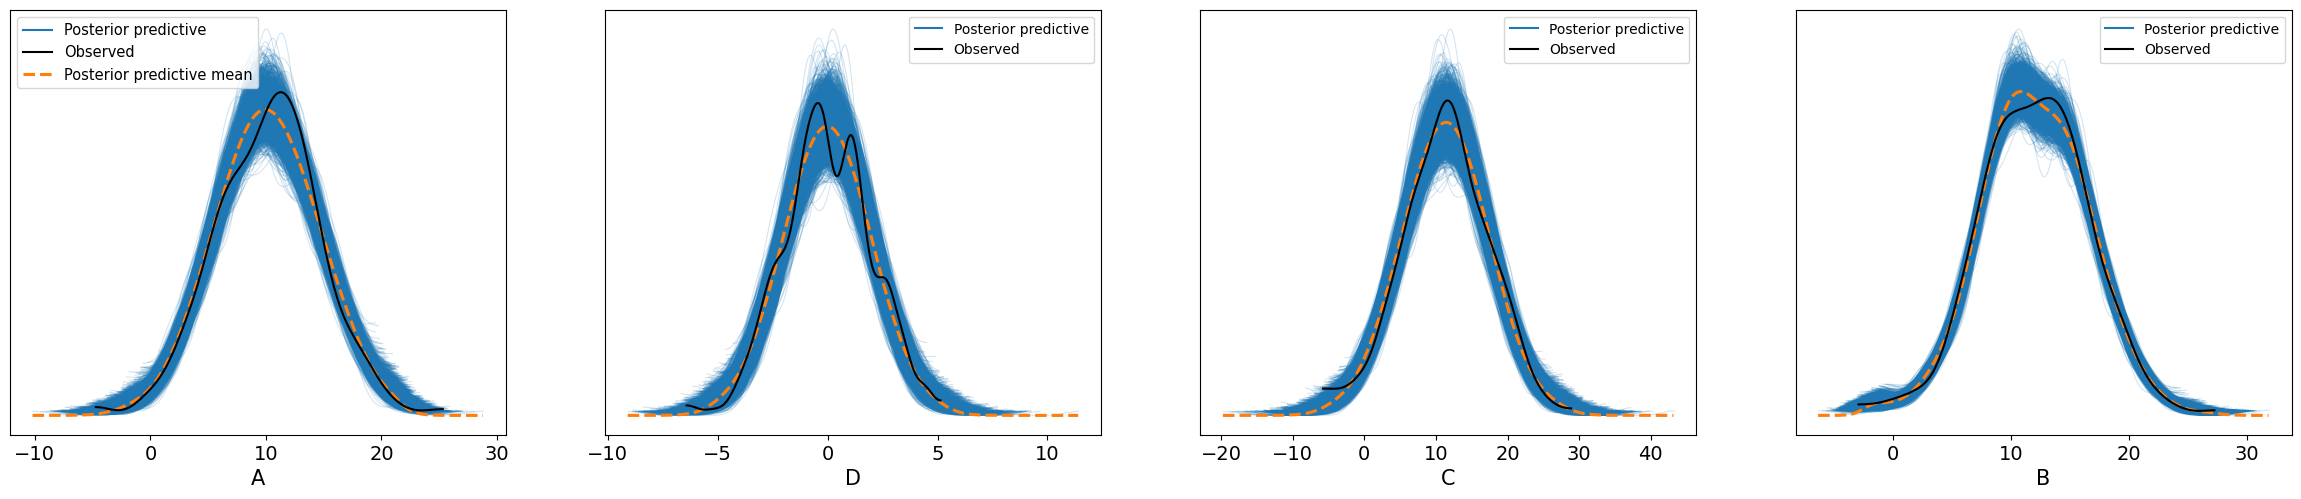

In [13]:
pm.plot_ppc(posterior)

In [1]:
from pymc_experimental.statespace import structural as st
import pymc as pm
import pytensor.tensor as pt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpyro
numpyro.set_host_device_count(4)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<Axes: >

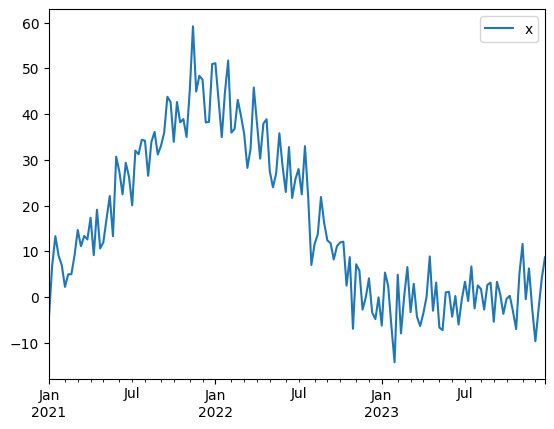

In [2]:
@np.vectorize
def theta(x):
  if x < 0:
    return 0
  if x >= 0:
    return 1
  
t = np.arange(156)
b = 1
t_50 = 50
t_100 = 100
b_100 = 1
b_50 = -2
x = t*b + theta(t-t_50)*b_50*(t-t_50) + theta(t-t_100)*b_100*(t-t_100) + 5*np.random.normal(size=156)

df = pd.DataFrame(index=pd.date_range("2021-01-01", periods=156, freq='W'), data={"x": x})
df.plot()

In [21]:

trend = st.LevelTrendComponent(order=2, innovations_order=[0, 1])

ss_mod = (trend).build()

with pm.Model(coords=ss_mod.coords) as model:
    P0 = pm.Deterministic('P0', pt.eye(ss_mod.k_states) * 1, dims=ss_mod.param_dims['P0'])
    intitial_trend = pm.Normal('initial_trend', sigma=1, dims=ss_mod.param_dims['initial_trend'])
    sigma_trend = pm.HalfNormal('sigma_trend', sigma=1, dims=ss_mod.param_dims['sigma_trend'])

    ss_mod.build_statespace_graph(df['x'], mode='JAX')
    idata = pm.sample(nuts_sampler='numpyro')

The following parameters should be assigned priors inside a PyMC model block: 
	initial_trend -- shape: (2,), constraints: None, dims: ('trend_state',)
	sigma_trend -- shape: (1,), constraints: Positive, dims: ('trend_shock',)
	P0 -- shape: (2, 2), constraints: Positive semi-definite, dims: ('state', 'state_aux')
The following MutableData variables should be assigned to the model inside a PyMC model block: 

Compiling...
Compilation time = 0:00:05.352404
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:26.911139
Transforming variables...
Transforming variables...
Transformation time = 0:00:00.046470


In [22]:
posterior = pm.sample_posterior_predictive(idata, model=model)

Sampling: [obs]


In [23]:
import arviz as az

In [6]:
#posterior.posterior_predictive.stack(sample=("chain", "draw", "observed_state")).obs

In [24]:
posterior.posterior_predictive.obs[:,:, :, 0]

<xarray.DataArray 'obs' (chain: 4, draw: 1000, time: 156)> Size: 5MB
array([[[-3.12461964e+00,  7.26563375e-01,  8.66520406e+00, ...,
         -2.10974569e+01,  1.04615481e+01,  2.47947943e+01],
        [-2.15512759e+00,  1.34150863e+00, -8.49374854e-02, ...,
         -1.64637562e+01,  1.26090185e+00,  2.55200267e+01],
        [-2.18066829e+00,  2.46072976e-01,  1.57512490e+01, ...,
         -9.45070059e+00,  1.12558760e+01,  1.35777124e+01],
        ...,
        [-1.41343515e+00,  9.63188612e-01,  2.34897990e+01, ...,
         -1.97220964e+01,  8.08957358e+00,  8.00725545e+00],
        [-2.25539100e+00, -9.31945695e-02,  1.18694252e+01, ...,
         -1.58754728e+01,  4.65363469e+00,  6.02975552e+00],
        [-1.97471935e-01,  3.02472769e+00,  2.22624228e+01, ...,
         -2.67745868e+01,  1.82718842e+01,  8.58966625e+00]],

       [[-1.02163282e+00,  1.98507250e+00,  2.70154578e+01, ...,
         -1.52746442e+01,  6.21025744e+00,  1.22666522e+01],
        [-2.14754076e+00,  7.31953449e-01,  1.47175558e+01, ...,
         -1.73809162e+01, -5.68040610e-02,  2.00835948e+01],
        [-2.10976522e+00,  3.74744848e-01,  3.16584729e+01, ...,
         -1.40487612e+01,  1.24066622e+00,  2.12555632e+01],
...
        [-1.78105301e+00,  1.33372501e+00,  1.24821462e+01, ...,
         -2.40935568e+01, -4.97925101e+00,  1.10549745e+01],
        [ 5.90232862e-01,  1.02269460e+00,  2.05100059e+01, ...,
         -1.71707446e+01,  2.90664465e+00,  1.12523599e+01],
        [-4.75402271e+00,  7.52295482e-01,  1.45081515e+01, ...,
         -1.34439334e+01, -1.40824886e+01, -4.04554590e-02]],

       [[-3.03037183e+00,  2.18776690e+00,  1.99969025e+01, ...,
         -4.01471229e+01, -1.24737196e+01, -1.75407083e+00],
        [-2.45007451e+00,  1.54805070e-01,  6.56342610e+00, ...,
         -2.50788358e+01,  1.41795010e+00,  2.58689534e+01],
        [-2.22871467e+00,  1.22713905e+00,  2.29406690e+01, ...,
         -1.58101211e+01, -6.94417679e+00,  1.01852185e+01],
        ...,
        [ 4.30842622e-01,  1.68029107e+00,  9.88291340e+00, ...,
         -1.40347611e+01,  8.59902307e+00, -7.30485671e+00],
        [-4.13630484e+00,  8.39828078e-01,  2.63951131e+01, ...,
         -8.29018000e+00,  8.91289162e+00,  1.99062532e+01],
        [-7.61780134e-01,  1.26108224e+00,  9.03500013e+00, ...,
         -2.02081496e+01, -4.51119700e+00,  1.68365474e+01]]])
Coordinates:
  * chain           (chain) int64 32B 0 1 2 3
  * draw            (draw) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * time            (time) datetime64[ns] 1kB 2021-01-03 ... 2023-12-24
    observed_state  <U4 16B 'data'

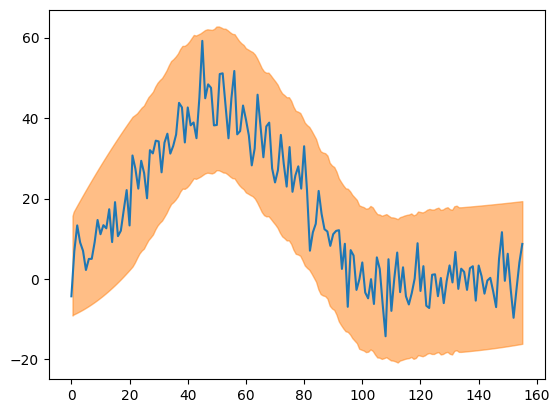

In [25]:
pm.plot_hdi(np.arange(156), posterior.posterior_predictive.obs[:,:, :, 0])
plt.plot(np.arange(156), df['x'])